# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [12]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'
# floyd run --gpu --env tensorflow-1.0 --data R5KrjnANiKVhLWAkpXhNBe --mode jupyter

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

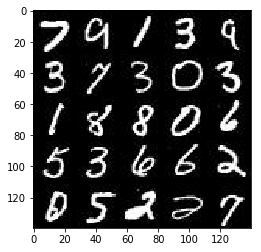

In [13]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

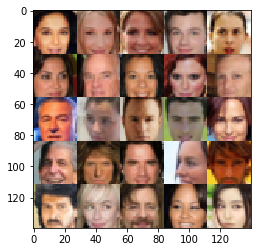

In [14]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [53]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input = tf.placeholder(tf.float32,(None,image_width,image_height,image_channels),name='real_input')
    z_input = tf.placeholder(tf.float32,(None,z_dim),name='z_input')
    lr = tf.placeholder(tf.float32)
    # TODO: Implement Function

    return real_input, z_input, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [54]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        #input 28x28x3
        l1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        #dont use  batch normalization in first layer
        l1 = tf.maximum(alpha * l1, l1)
        # 14x14x64
        l2 = tf.layers.conv2d(l1, 128, 5, strides=2, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        l2 = tf.layers.batch_normalization(l2, training=True)
        l2 = tf.maximum(alpha * l2, l2)
        #7x7x128
        l3 = tf.layers.conv2d(l2, 256, 5, strides=2, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        l3 = tf.layers.batch_normalization(l3, training=True)
        l3 = tf.maximum(alpha * l3, l3)
        #4x4x256
        l4 = tf.layers.conv2d(l3, 512, 5, strides=2, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        l4 = tf.layers.batch_normalization(l4, training=True)
        l4 = tf.maximum(alpha * l4, l4)
        #2x2x512

        # Flatten it
        l5 = tf.reshape(l4, (-1, 2*2*512))
        logits = tf.layers.dense(l5, 1,kernel_initializer=tf.random_normal_initializer(stddev=0.2))
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [55]:
def generator(z, out_channel_dim, is_train=True,alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):

        f1 = tf.layers.dense(z, 7*7*265,kernel_initializer=tf.random_normal_initializer(stddev=0.02))

        l1 = tf.reshape(f1, (-1, 7, 7, 265))
        l1 = tf.layers.batch_normalization(l1, training=is_train)
        l1 = tf.maximum(alpha * l1, l1)
        # 7x7x512
        
        l2 = tf.layers.conv2d_transpose(l1, 128, 5, strides=2, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        l2 = tf.layers.batch_normalization(l2, training=is_train)
        l2 = tf.maximum(alpha * l2, l2)
        # 14x14x128
        
        l3 = tf.layers.conv2d_transpose(l2, out_channel_dim, 5, strides=2, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        l3 = tf.layers.batch_normalization(l3, training=is_train)
        out = tf.tanh(l3)
        # 28x28x3 now

    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [56]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

   
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [57]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_updates = [opt for opt in  tf.get_collection(tf.GraphKeys.UPDATE_OPS) if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):   
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [58]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [59]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #tf.reset_default_graph()
        
    real_input, z_input, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
        
    d_loss, g_loss = model_loss(real_input, z_input,data_shape[3])
    
    d_opt , g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    n_img =25
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                _ = sess.run(d_opt, feed_dict={real_input: batch_images, z_input: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={z_input: batch_z, lr:learning_rate})

                if steps % 5== 0:
                    train_loss_d = d_loss.eval({z_input: batch_z, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Step {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, n_img, z_input, data_shape[3], data_image_mode)
                
        print("Traning Done!  ",
              "Discriminator Loss: {:.4f}.".format(train_loss_d),
              "Generator Loss: {:.4f}".format(train_loss_g))
        show_generator_output(sess, n_img, z_input, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Step 5... Discriminator Loss: 0.0011... Generator Loss: 141.8818
Epoch 1/2... Step 10... Discriminator Loss: 47.7414... Generator Loss: 143.3712
Epoch 1/2... Step 15... Discriminator Loss: 0.0093... Generator Loss: 65.2063
Epoch 1/2... Step 20... Discriminator Loss: 0.2728... Generator Loss: 7.5608
Epoch 1/2... Step 25... Discriminator Loss: 11.8602... Generator Loss: 2.9314
Epoch 1/2... Step 30... Discriminator Loss: 1.1931... Generator Loss: 10.6573
Epoch 1/2... Step 35... Discriminator Loss: 0.0290... Generator Loss: 7.8082
Epoch 1/2... Step 40... Discriminator Loss: 0.0000... Generator Loss: 67.7148
Epoch 1/2... Step 45... Discriminator Loss: 0.0000... Generator Loss: 78.2453
Epoch 1/2... Step 50... Discriminator Loss: 0.0000... Generator Loss: 55.8112
Epoch 1/2... Step 55... Discriminator Loss: 2.6811... Generator Loss: 3.6826
Epoch 1/2... Step 60... Discriminator Loss: 1.9009... Generator Loss: 10.2366
Epoch 1/2... Step 65... Discriminator Loss: 0.0000... Generator L

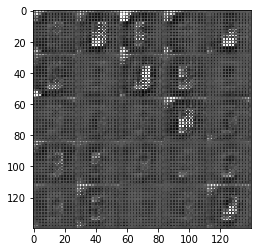

Epoch 1/2... Step 105... Discriminator Loss: 86.8303... Generator Loss: 98.2548
Epoch 1/2... Step 110... Discriminator Loss: 0.4265... Generator Loss: 7.0613
Epoch 1/2... Step 115... Discriminator Loss: 0.0310... Generator Loss: 7.8205
Epoch 1/2... Step 120... Discriminator Loss: 0.0288... Generator Loss: 5.9596
Epoch 1/2... Step 125... Discriminator Loss: 0.0278... Generator Loss: 4.8729
Epoch 1/2... Step 130... Discriminator Loss: 0.0935... Generator Loss: 3.5425
Epoch 1/2... Step 135... Discriminator Loss: 1.5782... Generator Loss: 0.3899
Epoch 1/2... Step 140... Discriminator Loss: 0.3472... Generator Loss: 1.7062
Epoch 1/2... Step 145... Discriminator Loss: 0.0838... Generator Loss: 2.9206
Epoch 1/2... Step 150... Discriminator Loss: 0.0585... Generator Loss: 3.1577
Epoch 1/2... Step 155... Discriminator Loss: 0.2901... Generator Loss: 1.8269
Epoch 1/2... Step 160... Discriminator Loss: 0.0060... Generator Loss: 6.4426
Epoch 1/2... Step 165... Discriminator Loss: 0.0071... Generat

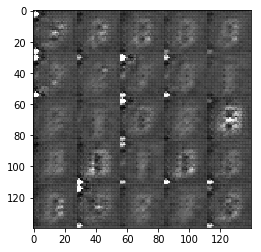

Epoch 1/2... Step 205... Discriminator Loss: 0.1306... Generator Loss: 5.4273
Epoch 1/2... Step 210... Discriminator Loss: 0.0049... Generator Loss: 10.6964
Epoch 1/2... Step 215... Discriminator Loss: 0.0852... Generator Loss: 3.5615
Epoch 1/2... Step 220... Discriminator Loss: 0.0127... Generator Loss: 7.1309
Epoch 1/2... Step 225... Discriminator Loss: 0.0065... Generator Loss: 6.6023
Epoch 1/2... Step 230... Discriminator Loss: 0.0214... Generator Loss: 5.8952
Epoch 1/2... Step 235... Discriminator Loss: 8.3728... Generator Loss: 24.1377
Epoch 1/2... Step 240... Discriminator Loss: 1.3937... Generator Loss: 1.9771
Epoch 1/2... Step 245... Discriminator Loss: 0.1776... Generator Loss: 3.3688
Epoch 1/2... Step 250... Discriminator Loss: 0.0290... Generator Loss: 7.8050
Epoch 1/2... Step 255... Discriminator Loss: 0.0095... Generator Loss: 8.9912
Epoch 1/2... Step 260... Discriminator Loss: 0.0663... Generator Loss: 4.5970
Epoch 1/2... Step 265... Discriminator Loss: 0.0414... Generat

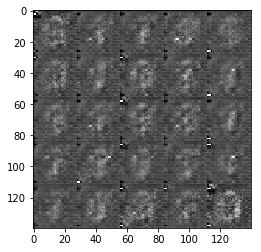

Epoch 1/2... Step 305... Discriminator Loss: 0.0030... Generator Loss: 9.8644
Epoch 1/2... Step 310... Discriminator Loss: 19.6401... Generator Loss: 0.0000
Epoch 1/2... Step 315... Discriminator Loss: 0.2922... Generator Loss: 17.4374
Epoch 1/2... Step 320... Discriminator Loss: 0.1276... Generator Loss: 3.5520
Epoch 1/2... Step 325... Discriminator Loss: 0.0947... Generator Loss: 3.2812
Epoch 1/2... Step 330... Discriminator Loss: 0.1199... Generator Loss: 2.8378
Epoch 1/2... Step 335... Discriminator Loss: 0.0405... Generator Loss: 5.5390
Epoch 1/2... Step 340... Discriminator Loss: 0.0662... Generator Loss: 3.4696
Epoch 1/2... Step 345... Discriminator Loss: 0.0475... Generator Loss: 3.7958
Epoch 1/2... Step 350... Discriminator Loss: 0.0927... Generator Loss: 3.2323
Epoch 1/2... Step 355... Discriminator Loss: 0.2454... Generator Loss: 2.0400
Epoch 1/2... Step 360... Discriminator Loss: 0.0449... Generator Loss: 16.5623
Epoch 1/2... Step 365... Discriminator Loss: 0.0131... Genera

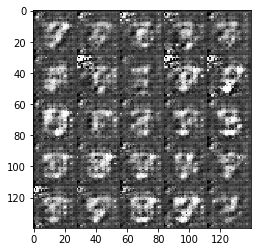

Epoch 1/2... Step 405... Discriminator Loss: 0.0580... Generator Loss: 7.0991
Epoch 1/2... Step 410... Discriminator Loss: 0.0633... Generator Loss: 11.5706
Epoch 1/2... Step 415... Discriminator Loss: 0.0786... Generator Loss: 3.1482
Epoch 1/2... Step 420... Discriminator Loss: 0.0234... Generator Loss: 4.6839
Epoch 1/2... Step 425... Discriminator Loss: 0.0285... Generator Loss: 4.4802
Epoch 1/2... Step 430... Discriminator Loss: 0.3151... Generator Loss: 1.7170
Epoch 1/2... Step 435... Discriminator Loss: 0.0863... Generator Loss: 5.0690
Epoch 1/2... Step 440... Discriminator Loss: 0.5628... Generator Loss: 1.2583
Epoch 1/2... Step 445... Discriminator Loss: 4.7580... Generator Loss: 0.0266
Epoch 1/2... Step 450... Discriminator Loss: 5.8120... Generator Loss: 14.9171
Epoch 1/2... Step 455... Discriminator Loss: 1.2978... Generator Loss: 9.5091
Epoch 1/2... Step 460... Discriminator Loss: 2.3346... Generator Loss: 0.6454
Epoch 1/2... Step 465... Discriminator Loss: 1.2942... Generat

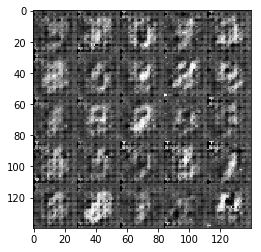

Epoch 2/2... Step 505... Discriminator Loss: 0.3260... Generator Loss: 1.7428
Epoch 2/2... Step 510... Discriminator Loss: 5.8091... Generator Loss: 11.5938
Epoch 2/2... Step 515... Discriminator Loss: 0.1510... Generator Loss: 2.9394
Epoch 2/2... Step 520... Discriminator Loss: 0.3197... Generator Loss: 1.5849
Epoch 2/2... Step 525... Discriminator Loss: 0.3815... Generator Loss: 1.6074
Epoch 2/2... Step 530... Discriminator Loss: 2.3824... Generator Loss: 11.0745
Epoch 2/2... Step 535... Discriminator Loss: 0.0471... Generator Loss: 4.2192
Epoch 2/2... Step 540... Discriminator Loss: 0.4616... Generator Loss: 1.2688
Epoch 2/2... Step 545... Discriminator Loss: 0.5153... Generator Loss: 1.0810
Epoch 2/2... Step 550... Discriminator Loss: 2.0072... Generator Loss: 0.1874
Epoch 2/2... Step 555... Discriminator Loss: 0.4149... Generator Loss: 2.5618
Epoch 2/2... Step 560... Discriminator Loss: 3.1299... Generator Loss: 0.0580
Epoch 2/2... Step 565... Discriminator Loss: 0.4321... Generat

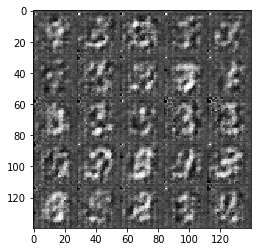

Epoch 2/2... Step 605... Discriminator Loss: 0.3526... Generator Loss: 1.4805
Epoch 2/2... Step 610... Discriminator Loss: 0.4961... Generator Loss: 1.0529
Epoch 2/2... Step 615... Discriminator Loss: 0.2471... Generator Loss: 1.8073
Epoch 2/2... Step 620... Discriminator Loss: 0.3019... Generator Loss: 1.6165
Epoch 2/2... Step 625... Discriminator Loss: 0.5403... Generator Loss: 1.0033
Epoch 2/2... Step 630... Discriminator Loss: 10.7874... Generator Loss: 0.0000
Epoch 2/2... Step 635... Discriminator Loss: 0.3688... Generator Loss: 1.3926
Epoch 2/2... Step 640... Discriminator Loss: 0.5538... Generator Loss: 0.9857
Epoch 2/2... Step 645... Discriminator Loss: 0.8721... Generator Loss: 0.6271
Epoch 2/2... Step 650... Discriminator Loss: 0.4447... Generator Loss: 2.1217
Epoch 2/2... Step 655... Discriminator Loss: 0.4681... Generator Loss: 1.1722
Epoch 2/2... Step 660... Discriminator Loss: 0.2631... Generator Loss: 1.7056
Epoch 2/2... Step 665... Discriminator Loss: 0.8089... Generato

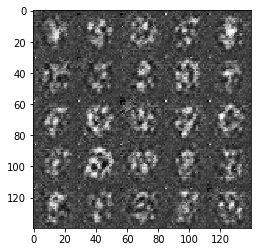

Epoch 2/2... Step 705... Discriminator Loss: 0.0380... Generator Loss: 3.9676
Epoch 2/2... Step 710... Discriminator Loss: 0.2753... Generator Loss: 1.6171
Epoch 2/2... Step 715... Discriminator Loss: 0.1414... Generator Loss: 2.2522
Epoch 2/2... Step 720... Discriminator Loss: 0.2552... Generator Loss: 1.7924
Epoch 2/2... Step 725... Discriminator Loss: 0.1327... Generator Loss: 2.5367
Epoch 2/2... Step 730... Discriminator Loss: 9.9692... Generator Loss: 4.6201
Epoch 2/2... Step 735... Discriminator Loss: 2.6415... Generator Loss: 0.2409
Epoch 2/2... Step 740... Discriminator Loss: 1.2061... Generator Loss: 1.2577
Epoch 2/2... Step 745... Discriminator Loss: 0.7560... Generator Loss: 0.7417
Epoch 2/2... Step 750... Discriminator Loss: 0.4055... Generator Loss: 1.8968
Epoch 2/2... Step 755... Discriminator Loss: 0.4755... Generator Loss: 1.2187
Epoch 2/2... Step 760... Discriminator Loss: 0.5738... Generator Loss: 1.2894
Epoch 2/2... Step 765... Discriminator Loss: 1.0672... Generator

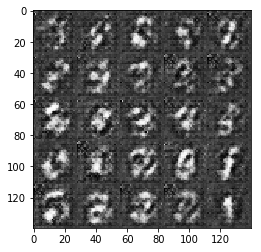

Epoch 2/2... Step 805... Discriminator Loss: 0.6232... Generator Loss: 1.0701
Epoch 2/2... Step 810... Discriminator Loss: 0.9164... Generator Loss: 0.8404
Epoch 2/2... Step 815... Discriminator Loss: 1.7506... Generator Loss: 2.4182
Epoch 2/2... Step 820... Discriminator Loss: 0.3016... Generator Loss: 2.3379
Epoch 2/2... Step 825... Discriminator Loss: 2.0692... Generator Loss: 5.0893
Epoch 2/2... Step 830... Discriminator Loss: 0.3291... Generator Loss: 1.5367
Epoch 2/2... Step 835... Discriminator Loss: 1.2429... Generator Loss: 5.2552
Epoch 2/2... Step 840... Discriminator Loss: 0.5289... Generator Loss: 0.9611
Epoch 2/2... Step 845... Discriminator Loss: 0.2179... Generator Loss: 4.2583
Epoch 2/2... Step 850... Discriminator Loss: 0.1244... Generator Loss: 2.4469
Epoch 2/2... Step 855... Discriminator Loss: 6.0057... Generator Loss: 14.2798
Epoch 2/2... Step 860... Discriminator Loss: 0.3098... Generator Loss: 2.5887
Epoch 2/2... Step 865... Discriminator Loss: 1.1685... Generato

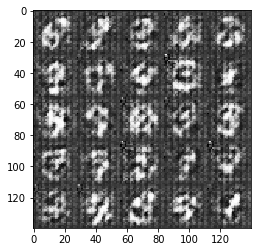

Epoch 2/2... Step 905... Discriminator Loss: 0.2090... Generator Loss: 1.9664
Epoch 2/2... Step 910... Discriminator Loss: 0.1269... Generator Loss: 3.8782
Epoch 2/2... Step 915... Discriminator Loss: 0.0788... Generator Loss: 3.1248
Epoch 2/2... Step 920... Discriminator Loss: 0.0994... Generator Loss: 2.8621
Epoch 2/2... Step 925... Discriminator Loss: 0.0639... Generator Loss: 3.3816
Epoch 2/2... Step 930... Discriminator Loss: 0.1220... Generator Loss: 2.4791
Epoch 2/2... Step 935... Discriminator Loss: 0.0391... Generator Loss: 3.6843
Traning Done!   Discriminator Loss: 0.0391. Generator Loss: 3.6843


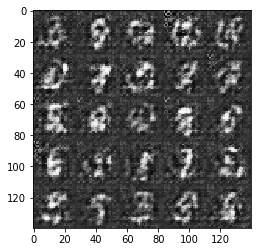

In [60]:
batch_size = 128
z_dim = 200#512
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = None
z_dim = None
learning_rate = None
beta1 = None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.